# Expected ET response

Using Claire's regression coefficients from the online vs. offline PPE runs, compute the expected ET response to parameter perturbations from the offline CLM5.0 PPE

Caveat: the regression coefficents were computed from preindustrial simulations

# 1. Setup

In [1]:
%load_ext watermark
%load_ext autoreload

import glob
import copy

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import cmocean.cm as cmo

import sys
sys.path.append('/glade/u/home/bbuchovecky/projects/cpl_ppe_co2/utils')
import cpl_ppe_co2 as ppe
%aimport cpl_ppe_co2
%autoreload 1

%watermark -iv -co -v

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.16.1

conda environment: clisci

numpy     : 1.24.4
cartopy   : 0.22.0
xarray    : 2023.10.1
pandas    : 2.2.0
cmocean   : 3.0.3
matplotlib: 3.8.0
sys       : 3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 10:40:35) [GCC 12.3.0]



In [2]:
mpl.rcParams['figure.dpi'] = 150

## 1.1. Dask

Only need if loading PPE output as Datasets or computing rankings

In [3]:
# Create Dask cluster and client, scale up to 20 workers
# cluster, client = ppe.get_ClusterClient(walltime='02:00:00')
# cluster.scale(20)

In [4]:
## Check the status of the cluster
# client

## Prints the PBS job script that is used to submit the Dask workers
# print(cluster.job_script())

## Lists active workers and their status
# cluster.workers

## Lists current jobs in Casper queue
# !qstat -u $USER

## 1.2. Functions

Basic utility functions for loading and manipulating the PPE output. Mostly from Daniel Kennedy / Claire Zarakas

In [3]:
def get_map(da, sgmap=None):
    ''' (Code from Daniel Kennedy) '''
    if not sgmap:
        sgmap = xr.open_dataset('sgmap.nc')
    return da.sel(gridcell=sgmap.cclass).where(sgmap.notnan).compute()

In [4]:
def recalc_mean(ds, datavar, cfvar):
    '''
    Compute spatial mean of gridded temporal mean, multiply
    by 365 to account for precomputed conversion factor
    '''
    cf = cfs[cfvar]
    x = ds[datavar]

    return (x * la).sum(dim='gridcell') * float(cf) * 365

In [5]:
inputpath = '/glade/campaign/cgd/tss/people/czarakas/CoupledPPE/coupled_simulations'
lnd_h0 = xr.open_dataset(inputpath+'/COUP0000_PI_SOM/lnd/hist/COUP0000_PI_SOM.clm2.h0.0049-02-01-00000.nc')
la = lnd_h0['area']

def calc_gridded_mean(ds, varname):
    ''' Add docstring '''
    x = ds[varname]
    return (la * x).sum(dim=['lat', 'lon']) / la.sum(dim=['lat', 'lon'])

## 1.3. Load data and rankings

In [6]:
varname = 'EFLX_LH_TOT'

# CLM5 PPE
f = '/glade/u/home/djk2120/ppe_clean/postp/OAAT_surv.nc'
ds = xr.open_dataset(f)
ds = ds[[s for s in list(ds.keys()) if varname in s]]  # select variables with v in name

# Sparse grid land area
la = xr.open_dataset('./sparsegrid_landarea.nc').landarea  # gridcell km2

# Conversion factor for EFLX_LH_TOT
cfs = ppe.load_dict('cfs.csv')

# Slopes from offline vs. online CESM PPE
dir_in = '/glade/work/czarakas/ET_modulation/regressions/'

f = 'QFLX_EVAP_TOT_offline_vs_QFLX_EVAP_TOT_coupled_slope.nc'
slope = xr.open_dataset(dir_in+f)['__xarray_dataarray_variable__'].rename('slope')

f = 'pval_QFLX_EVAP_TOT_offline_vs_QFLX_EVAP_TOT_coupled_slope.nc'
pval = xr.open_dataset(dir_in+f)['__xarray_dataarray_variable__'].rename('pval')

# Rankings
df = pd.read_csv(f'./rank/{varname}_params_rank_all.csv')
key = list(df.columns[1:])

## 1.4. Define constants

In [7]:
kind = ['RNK', 'RNG']
meas = ['mean', 'iav']
forc = ['C285', 'C867', 'AF1855', 'AF2095', 'AF2095-AF1855', 'C867-C285']
biom = {
    'BF':    'Boreal forest',
    'SD':    'Subtropical desert',
    'TmGD':  'Temperate grassland/desert',
    'TmRF':  'Temperate rain forest',
    'TmSF':  'Temperate seasonal forest',
    'TrRF':  'Tropical rain forest',
    'TrSFS': 'Tropical seasonal forest/savanna',
    'Tu':    'Tundra',
    'WS':    'Woodland/shrubland',
    'GB':    'global',
}

# 2. Compute expected ET response

**currently:** load precomputed [mean,std,amp] -> convert gridcell to lat/lon -> scale based on expected coupled response -> take spatial mean with lat/lon land area array

**better:** load ensemble -> convert gridcell to lat/lon -> scale based on expected coupled response -> take spatial mean with lat/lon land area array -> take temporal [mean,std,amp]

need to somehow mask the land area array with biome regions to compute spatial biome [mean,std,amp] of expected coupled response

rank the 

## 2.1. Compute from Daniel Kennedy's aggregated Dataset
The averaging might be slightly different than if I used the raw PPE output (like in my parameter ranking notebook).

In [14]:
dirout = '/glade/work/bbuchovecky/CPL_PPE_CO2'

In [21]:
%%time
gridded = []
scaled = []
for v in list(ds.keys()):
    if 'gridded' in v:
        grid = get_map(ds[v])
        grid.name = v
        grid.attrs = ds[v].attrs
        gridded.append(grid)

        scale = grid * slope
        scale.name = f'{v}_scaled'
        scale.attrs = ds[v].attrs
        scaled.append(scale)

gridded = xr.merge(gridded)
gridded.to_netcdf(f'{dirout}/select_parameters/{varname}_offline_gridded.nc')

scaled = xr.merge(scaled)
scaled.to_netcdf(f'{dirout}/select_parameters/{varname}_offline_scaled_gridded.nc')

CPU times: user 29.4 s, sys: 8.17 s, total: 37.6 s
Wall time: 37 s


In [22]:
%%time
gridded_zonal = gridded.mean(dim='lon')
gridded_zonal.to_netcdf(f'{dirout}/select_parameters/{varname}_offline_zonal.nc')

scaled_zonal = scaled.mean(dim='lon')
scaled_zonal.to_netcdf(f'{dirout}/select_parameters/{varname}_offline_scaled_zonal.nc')

CPU times: user 876 ms, sys: 345 ms, total: 1.22 s
Wall time: 1.2 s


In [ ]:
%%time
scaled_gb_mean = []
for v in list(scaled.keys()):
    da = calc_gridded_mean(scaled, v)
    da.name = v
    da.attrs = scaled[v].attrs
    scaled_gb_mean.append(da)

scaled_gb_mean = xr.merge(scaled_gb_mean)
scaled_gb_mean.to_netcdf(f'{dirout}/select_parameters/{varname}_offline_scaled_global.nc')

## 2.2. Load data computed in previous section

In [8]:
dirout = '/glade/work/bbuchovecky/CPL_PPE_CO2'

gridded = xr.open_dataset(f'{dirout}/select_parameters/{varname}_offline_gridded.nc')
scaled = xr.open_dataset(f'{dirout}/select_parameters/{varname}_offline_scaled_gridded.nc')
gridded_zonal = xr.open_dataset(f'{dirout}/select_parameters/{varname}_offline_zonal.nc')
scaled_zonal = xr.open_dataset(f'{dirout}/select_parameters/{varname}_offline_scaled_zonal.nc')
scaled_gb_mean = xr.open_dataset(f'{dirout}/select_parameters/{varname}_offline_scaled_global.nc')

## 2.3. Plot scaled response

In [ ]:
def get_discrete_colors(cmap_name, n):
    cmap = plt.get_cmap(cmap_name)
    colors = [cmap(i) for i in np.linspace(0.15, 0.85, n)]
    return colors

### 2.3.1. Zonal mean

In [217]:
dv = 'EFLX_LH_TOT_gridded_mean'
gridded_zonal_range = abs(gridded_zonal[dv].sel(minmax='max') - gridded_zonal[dv].sel(minmax='min'))
gridded_zonal_delta = gridded_zonal[dv] - gridded_zonal[dv].sel(param='default')

In [218]:
dv = 'EFLX_LH_TOT_gridded_mean_scaled'
scaled_zonal_range = abs(scaled_zonal[dv].sel(minmax='max') - scaled_zonal[dv].sel(minmax='min'))
scaled_zonal_delta = scaled_zonal[dv] - scaled_zonal[dv].sel(param='default')

In [ ]:
# for x in vals:
#     selected = da.sel({dim:x})
#     stack_dims = [d for d in selected.dims if d != 'lat']
#     stacked = selected.stack(_=stack_dims)
#     for i in range(len(stacked._)):
#         ##

def match_axlim(axs, xy):
    lims = []
    for ax in axs:
        lims.append(ax.get_xlim() if xy == 'x' else ax.get_ylim())
    lims = np.array(lims)
    lims = [lims.min(), lims.max()]
    for ax in axs:
        if xy == 'x':
            ax.set_xlim(lims)
        else:
            ax.set_ylim(lims)

def _plot_zm(da, dim, ax, **kwargs):
    for x in da[dim].values:
        da.sel({dim:x}).plot(ax=ax, **kwargs)

def plot_zm_list(da, ps, ax, colors=None, **kwargs):
    for j, p in enumerate(ps):
        dap = da.sel(param=p)
        for i in range(2):
            lb = None
            if i == 0:
                lb = p
            if len(colors) == len(ps)/2:
                dap.isel(minmax=i).plot(ax=ax, color=colors[j//2], label=lb, **kwargs)
            elif type(colors) == list and len(colors) == len(ps):
                dap.isel(minmax=i).plot(ax=ax, color=colors[j], label=lb, **kwargs)
            elif colors is not None:
                dap.isel(minmax=i).plot(ax=ax, color=colors, label=lb, **kwargs)
            else:
                dap.isel(minmax=i).plot(ax=ax, label=lb, **kwargs)

def plot_zm_panel(da_raw, da_scl, f, n):
    da_raw = da_raw.sel(exp=f)
    da_scl = da_scl.sel(exp=f)

    colname = f'RNK_{f}_GB_mean'
    ps = list(df.loc[df[colname]<=n].sort_values(colname)['param_name'])

    fig, axs = plt.subplots(1, 2, figsize=(13, 4), layout='tight')
    cs = get_discrete_colors(cmo.matter_r, n)

    for i, (da, ax) in enumerate(zip([da_raw, da_scl], axs)):
        _plot_zm(da.stack(_=('param', 'minmax')), '_', ax, c='silver', alpha=0.5)
        plot_zm_list(da, ps, ax, cs, alpha=0.75, lw=1.5)
        ax.axhline(0, c='k', ls=(0, (5, 10)), lw=mpl.rcParams['axes.linewidth'])
        ax.legend()
        ax.set_xlabel('Latitude [degrees N]')
        ax.set_ylabel('$\Delta$EFLX_LH_TOT [W m$^{-2}$]')
        ax.set_title(None)
    
    match_axlim(axs, 'y')
    match_axlim(axs, 'x')

    axs[0].set_title(f'{f}, zonal mean', loc='left')
    axs[1].set_title(f'{f}, zonal mean, scaled using land-atmos sensitivity', loc='left')

    return fig, axs

In [ ]:
dirout = './scaled'
n = 5
for f in ['AF2095', 'C867', 'AF1855', 'C285']:
    fig, axs = plot_zm_panel(gridded_zonal_delta, scaled_zonal_delta, f, n)
    fig.savefig(f'{dirout}/EFLX_LH_TOT_zonal_panel_{f}_all.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.close(fig)

In [49]:
def plot_zm(v, f, p, do_def=False, ax=None, ylim=[None, None], do_xlabel=True):
    ''' Add docstring '''
    if not ax:
        fig, ax = plt.subplots(figsize=(6, 4))

    pmin_raw = gridded_zonal[v].sel(exp=f, param=p, minmax='min')
    pmax_raw = gridded_zonal[v].sel(exp=f, param=p, minmax='max')
    pmin_raw.plot(ax=ax, c='tab:blue', lw=2, linestyle=(0, (5, 1)))
    pmax_raw.plot(ax=ax, c='tab:blue', lw=2, linestyle='-')
    ax.fill_between(gridded_zonal.lat, pmin_raw, pmax_raw, color='tab:blue', alpha=0.25, label='CLM5PPE')

    pmin_scl = scaled_zonal[f'{v}_scaled'].sel(exp=f, param=p, minmax='min')
    pmax_scl = scaled_zonal[f'{v}_scaled'].sel(exp=f, param=p, minmax='max')
    pmin_scl.plot(ax=ax, c='tab:orange', lw=2, linestyle=(0, (5, 1)))
    pmax_scl.plot(ax=ax, c='tab:orange', lw=2, linestyle='-')
    ax.fill_between(scaled_zonal.lat, pmin_scl, pmax_scl, color='tab:orange', alpha=0.25, label='CLM5PPE_scaled')

    if do_def:
        gridded_zonal[v].sel(exp=f, param='default', minmax='max').plot(ax=ax, c='tab:blue', lw=2, linestyle=':', label='default')
        scaled_zonal[f'{v}_scaled'].sel(exp=f, param='default', minmax='max').plot(ax=ax, c='tab:orange', lw=2, linestyle=':', label='default_scaled')

    ax.legend()
    ax.set_ylabel('EFLX_LH_TOT [W m$^{-2}$]')
    if do_xlabel:
        ax.set_xlabel('Latitude [degrees N]')
    if not do_xlabel:
        ax.set_xlabel('')
    ax.set_xlim(-57.5, 86)
    ax.set_ylim(ylim[0], ylim[1])
    ax.set_title(f'{f}, {p}')

In [50]:
def plot_zm_range(v, f, p, ax=None, ylim=[None, None], do_xlabel=True):
    ''' Add docstring '''
    if not ax:
        fig, ax = plt.subplots(figsize=(6, 4))

    pmin_raw = gridded_zonal[v].sel(exp=f, param=p, minmax='min')
    pmax_raw = gridded_zonal[v].sel(exp=f, param=p, minmax='max')
    abs(pmin_raw-pmax_raw).plot(ax=ax, c='tab:blue', lw=2, linestyle='-', label='CLM5PPE')

    pmin_scl = scaled_zonal[f'{v}_scaled'].sel(exp=f, param=p, minmax='min')
    pmax_scl = scaled_zonal[f'{v}_scaled'].sel(exp=f, param=p, minmax='max')
    abs(pmin_scl-pmax_scl).plot(ax=ax, c='tab:orange', lw=2, linestyle='-', label='CLM5PPE_scaled')

    ax.legend()
    ax.set_ylabel('$\Delta$EFLX_LH_TOT [W m$^{-2}$]')
    if do_xlabel:
        ax.set_xlabel('Latitude [degrees N]')
    if not do_xlabel:
        ax.set_xlabel('')
    ax.set_xlim(-57.5, 86)
    ax.set_ylim(ylim[0], ylim[1])
    ax.set_title(f+', '+p+', $|x_{pmax}-x_{pmin}|$')

In [60]:
dirout = './scaled'

n = 5
v = 'EFLX_LH_TOT_gridded_mean'
f = 'AF2095'

for f in ['C285', 'C867', 'AF1855', 'AF2095']:
    colname = f'RNK_{f}_GB_mean'
    ps = list(df.loc[df[colname]<=n].sort_values(colname)['param_name'])

    fig, axs = plt.subplots(n, 2, figsize=(10, 16))
    for i, p in enumerate(ps):
        plot_zm(v, f, p, ax=axs[i,0], do_xlabel=False)
        plot_zm_range(v, f, p, ax=axs[i,1], do_xlabel=False)
        axs[i,0].set_title('Rank '+str(i+1), fontsize=12, fontweight='bold', loc='left')

    axs[-1,0].set_xlabel('Latitude [degrees N]')
    axs[-1,1].set_xlabel('Latitude [degrees N]')
    fig.tight_layout()
    fig.savefig(f'{dirout}/EFLX_LH_TOT_zonal_scaled_{f}_top{n}.png', dpi=300)
    plt.close(fig)

### 2.3.2. Global mean

In [134]:
v = 'EFLX_LH_TOT'
f = 'AF'
p = 'fff'
xvar = 'coupling'  # 'forcing' or 'coupling'

def plot_global(v, f, p, xvar, ax=None, do_format=True, c='tab:blue'):
    ''' Add docstring '''
    if not ax:
        fig, ax = plt.subplots(figsize=(6, 4))

    if f == 'AF':
        pi = 'AF1855'
        ssp = 'AF2095'
    elif f == 'C':
        pi = 'C285'
        ssp = 'C867'

    pmin_raw_pi = ds[v+'_global_mean'].sel(exp=pi, param=p, minmax='min')
    pmax_raw_pi = ds[v+'_global_mean'].sel(exp=pi, param=p, minmax='max')

    pmin_raw_ssp = ds[v+'_global_mean'].sel(exp=ssp, param=p, minmax='min')
    pmax_raw_ssp = ds[v+'_global_mean'].sel(exp=ssp, param=p, minmax='max')

    pmin_scl_pi = scaled_gb_mean[v+'_gridded_mean_scaled'].sel(exp=pi, param=p, minmax='min')
    pmax_scl_pi = scaled_gb_mean[v+'_gridded_mean_scaled'].sel(exp=pi, param=p, minmax='max')

    pmin_scl_ssp = scaled_gb_mean[v+'_gridded_mean_scaled'].sel(exp=ssp, param=p, minmax='min')
    pmax_scl_ssp = scaled_gb_mean[v+'_gridded_mean_scaled'].sel(exp=ssp, param=p, minmax='max')

    if xvar == 'forcing':
        ax.plot([1, 2], [abs(pmin_raw_pi-pmax_raw_pi), abs(pmin_raw_ssp-pmax_raw_ssp)], c=c, lw=2, linestyle='-', marker='o', label=p)
        ax.plot([1, 2], [abs(pmin_scl_pi-pmax_scl_pi), abs(pmin_scl_ssp-pmax_scl_ssp)], c=c, lw=2, linestyle=(0, (5, 1)), marker='o')
        ax.set_xticks([1, 2])
        ax.set_xticklabels([pi, ssp])
    elif xvar == 'coupling':
        ax.plot([1, 2], [abs(pmin_raw_pi-pmax_raw_pi), abs(pmin_scl_pi-pmax_scl_pi)], c=c, lw=2, linestyle='-', marker='o', label=p)
        ax.plot([1, 2], [abs(pmin_raw_ssp-pmax_raw_ssp), abs(pmin_scl_ssp-pmax_scl_ssp)], c=c, lw=2, linestyle=(0, (5, 1)), marker='o')
        ax.set_xticks([1, 2])
        ax.set_xticklabels(['CLM5PPE', 'CLM5PPE_scaled'])

    ax.set_xlim(0.8, 2.9)

    if not ax or do_format:
        ax.set_ylabel('$\Delta$'+v+' [W m$^{-2}$]')
        ax.legend(loc='upper right')

In [158]:
n = 5
v = 'EFLX_LH_TOT'

f = 'C'
rank_f = 'C285'
xvar = 'forcing'

colname = f'RNK_{rank_f}_GB_mean'
ps = list(df.loc[df[colname]<=n].sort_values(colname)['param_name'])

fig, ax = plt.subplots(figsize=(6, 4))
cs = get_discrete_colors(cmo.matter_r, n)
for i, p in enumerate(ps):
    plot_global(v, f, p, xvar, ax=ax, do_format=False, c=cs[i])
ax.legend(fontsize=8, loc='upper right')
ax.set_ylabel('$\Delta$'+v+' [W m$^{-2}$]')
ax.set_title(f'global mean of top {n} parameters from {colname}\n[solid=CLM5PPE, dashed=CLM5PPE_scaled]', loc='left')
fig.tight_layout()
fig.savefig(f'{dirout}/EFLX_LH_TOT_global_forc_{f}top{n}_{colname}.png', dpi=300)
plt.close(fig)

In [162]:
n = 5
v = 'EFLX_LH_TOT'

f = 'C'
rank_f = 'C867'
xvar = 'coupling'

colname = f'RNK_{rank_f}_GB_mean'
ps = list(df.loc[df[colname]<=n].sort_values(colname)['param_name'])

if f == 'AF':
    pi = 'AF1855'
    ssp = 'AF2095'
elif f == 'C':
    pi = 'C285'
    ssp = 'C867'

fig, ax = plt.subplots(figsize=(6, 4))
cs = get_discrete_colors(cmo.matter_r, n)
for i, p in enumerate(ps):
    plot_global(v, f, p, xvar, ax=ax, do_format=False, c=cs[i])
ax.legend(fontsize=8, loc='upper right')
ax.set_ylabel('$\Delta$'+v+' [W m$^{-2}$]')
ax.set_title(f'global mean of top {n} parameters from {colname}\n[solid={pi}, dashed={ssp}]', loc='left')
fig.tight_layout()

fig.savefig(f'{dirout}/EFLX_LH_TOT_global_coup_{f}top{n}_{colname}.png', dpi=300)
plt.close(fig)

# Misc.

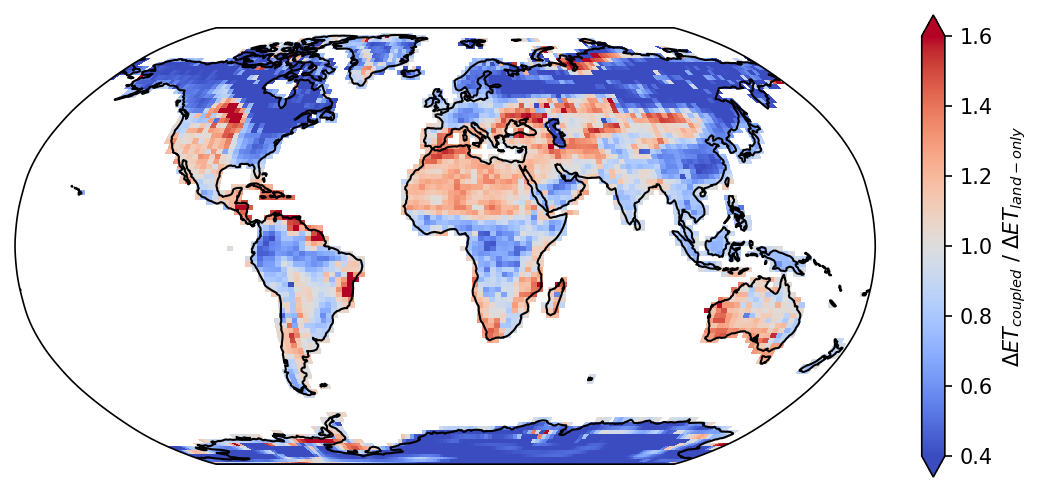

In [61]:
fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={'projection': ccrs.Robinson()})
slope.plot(
    ax=ax,
    vmin=0.4, vmax=1.6, cmap='coolwarm',
    transform=ccrs.PlateCarree(),
    add_colorbar=True, cbar_kwargs={'fraction': 0.025, 'label': '$\Delta ET_{coupled}$ / $\Delta ET_{land-only}$'},)
ax.coastlines()

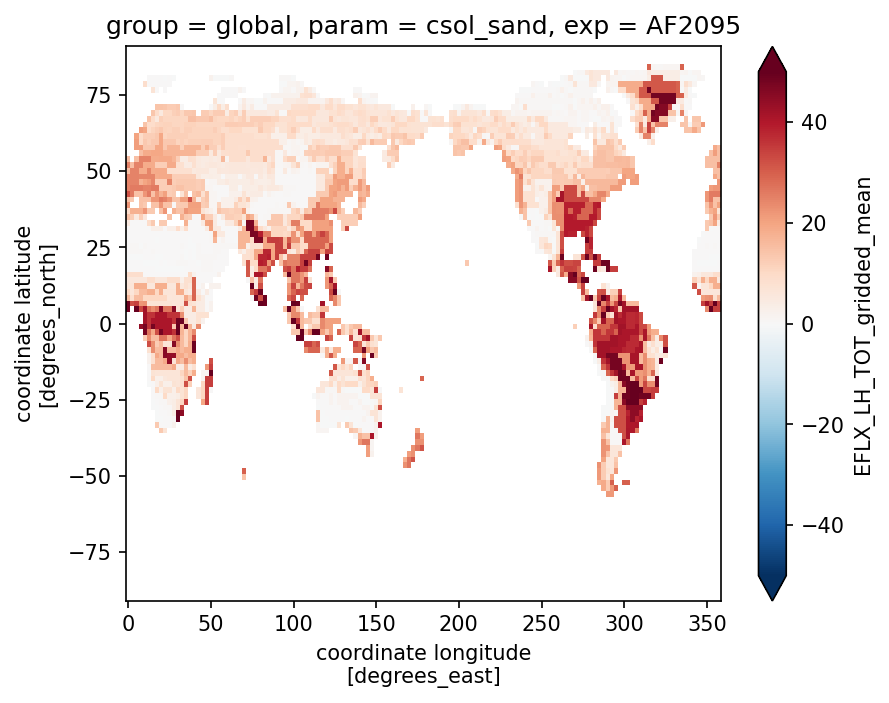

In [87]:
et_max = ds.EFLX_LH_TOT_gridded_mean.sel(exp='AF2095', param='csol_sand', minmax='max')
et_min = ds.EFLX_LH_TOT_gridded_mean.sel(exp='AF2095', param='csol_sand', minmax='min')
map_et_max = get_map(et_max)
map_et_min = get_map(et_min)

(map_et_max - map_et_min).plot(vmin=-50, vmax=50, cmap='RdBu_r', extend='both')

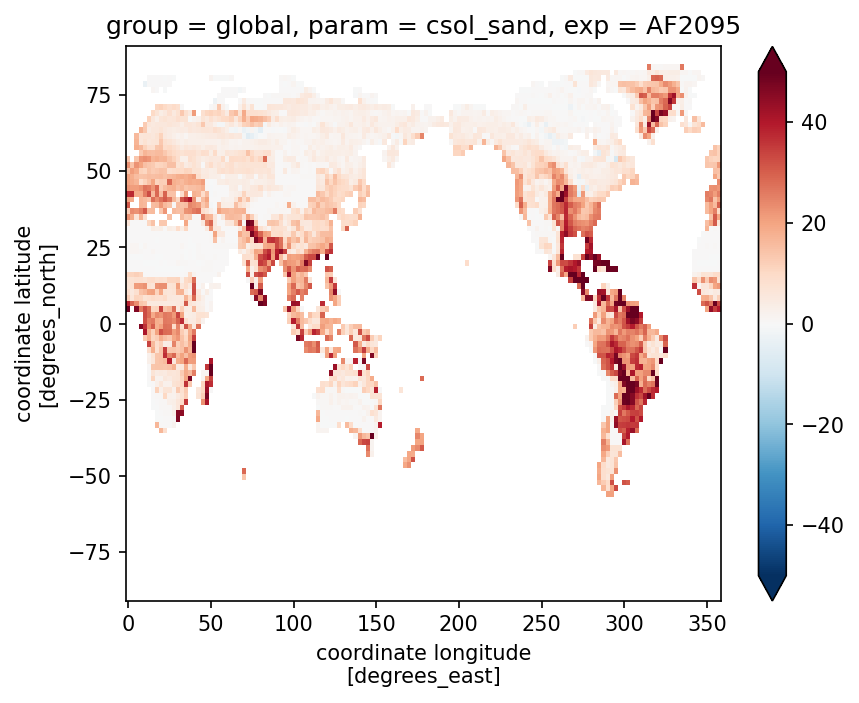

In [86]:
map_et_max_atm = map_et_max * slope
map_et_min_atm = map_et_min * slope
(map_et_max_atm - map_et_min_atm).plot(vmin=-50, vmax=50, cmap='RdBu_r', extend='both')

# !! KILL DASK !!

(don't want to get spammed with PBS emails when the workers time out)

In [ ]:
# client.shutdown()
# !rm ./dask-worker.e*
# !rm ./dask-worker.o*